## Data Extraction

In [5]:
pip install kaggle

In [11]:

import json
import os

kaggle_json = {
    "username": "vibh3203",
    "key": "KGAT_2fe1dba4482de18abd287fb2b021c887"
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

os.chmod("/root/.kaggle/kaggle.json", 0o600)

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



!kaggle datasets download -d shrutimehta/dermatology-dataset

!unzip -o dermatology-dataset.zip

## Data Cleaning

In [12]:
df=pd.read_csv("/content/dermatology_database_1.csv")

In [13]:
df.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_and_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_damage_basal_layer,spongiosis,saw_tooth_appearance_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_mononuclear_infiltrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3


In [16]:
# -----------------------------
# STEP 1: Import libraries
# -----------------------------
import pandas as pd
import numpy as np


column_names = [
    'erythema','scaling','definite_borders','itching','koebner_phenomenon',
    'polygonal_papules','follicular_papules','oral_mucosal_involvement',
    'knee_elbow_involvement','scalp_involvement','family_history','melanin_incontinence',
    'eosinophils_infiltrate','PNL_infiltrate','fibrosis_papillary_dermis',
    'exocytosis','acanthosis','hyperkeratosis','parakeratosis','clubbing_rete_ridges',
    'elongation_rete_ridges','thinning_suprapapillary_epidermis','spongiform_pustule',
    'munro_microabcess','focal_hypergranulosis','disappearance_granular_layer',
    'vacuolisation_basal_layer','spongiosis','saw_tooth_appearance_retes',
    'follicular_horn_plug','perifollicular_parakeratosis','inflammatory_monoluclear_infiltrate',
    'band_like_infiltrate','age','class'
]

df.columns = column_names

# -----------------------------
# STEP 4: Handle missing age values
# -----------------------------
# Replace '?' with NaN
df['age'] = df['age'].replace('?', np.nan)

# Convert age column to numeric
df['age'] = pd.to_numeric(df['age'])

# Fill missing age values with median
df['age'].fillna(df['age'].median(), inplace=True)

# -----------------------------
# STEP 5: Ensure all other columns are numeric
# -----------------------------
for col in df.columns[:-2]:  # skip age and class
    df[col] = pd.to_numeric(df[col])

# -----------------------------
# STEP 6: Optional - Check for outliers
# -----------------------------
# Example using simple IQR method
Q1 = df.select_dtypes(include=[np.number]).quantile(0.25)
Q3 = df.select_dtypes(include=[np.number]).quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Number of outliers per column:\n", outliers)

# -----------------------------
# STEP 7: Separate features and target
# -----------------------------
X = df.drop('class', axis=1)
y = df['class']

# -----------------------------
# STEP 8: Quick check
# -----------------------------
print("Shape of dataset:", df.shape)
print("Columns:", df.columns.tolist())


Number of outliers per column:
 erythema                               151
scaling                                  0
definite_borders                         0
itching                                  0
koebner_phenomenon                      18
polygonal_papules                       69
follicular_papules                      33
oral_mucosal_involvement                67
knee_elbow_involvement                  23
scalp_involvement                       16
family_history                          46
melanin_incontinence                    70
eosinophils_infiltrate                  42
PNL_infiltrate                           7
fibrosis_papillary_dermis               54
exocytosis                               0
acanthosis                             156
hyperkeratosis                           5
parakeratosis                            0
clubbing_rete_ridges                     0
elongation_rete_ridges                   0
thinning_suprapapillary_epidermis       31
spongiform_pustule    

/tmp/ipython-input-706637366.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)


In [19]:
# Make a copy of the dataframe
df_clean = df.copy()

# Function to cap values at 1% and 99%
def cap_outliers(series):
    lower = series.quantile(0.01)
    upper = series.quantile(0.99)
    return np.clip(series, lower, upper)

# Apply to all numeric columns except 'class'
numeric_cols = df_clean.columns.drop('class')
for col in numeric_cols:
    df_clean[col] = cap_outliers(df_clean[col])

# Check again for outliers using IQR
Q1 = df_clean[numeric_cols].quantile(0.25)
Q3 = df_clean[numeric_cols].quantile(0.75)
IQR = Q3 - Q1




In [30]:
df.head()

,erythema,scaling,definite_borders,itching,koebner_phenomenon,polygonal_papules,follicular_papules,oral_mucosal_involvement,knee_elbow_involvement,scalp_involvement,...,disappearance_granular_layer,vacuolisation_basal_layer,spongiosis,saw_tooth_appearance_retes,follicular_horn_plug,perifollicular_parakeratosis,inflammatory_monoluclear_infiltrate,band_like_infiltrate,age,class
0,2,2,0,3,0,0,0,0,1,0,...,0,0,3,0,0,0,1,0,55.0,2
1,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8.0,1
2,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26.0,3
3,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40.0,1
4,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45.0,3


## Exploratory Data Analysis

/tmp/ipython-input-1565624720.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df_clean, palette='Set2')


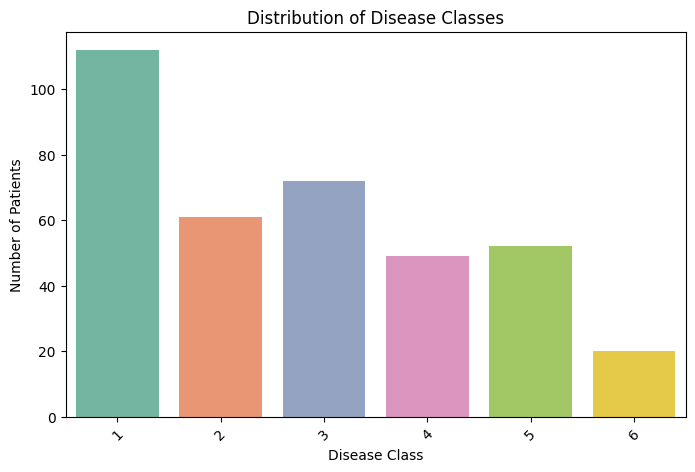

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='class', data=df_clean, palette='Set2')
plt.title('Distribution of Disease Classes')
plt.xlabel('Disease Class')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()


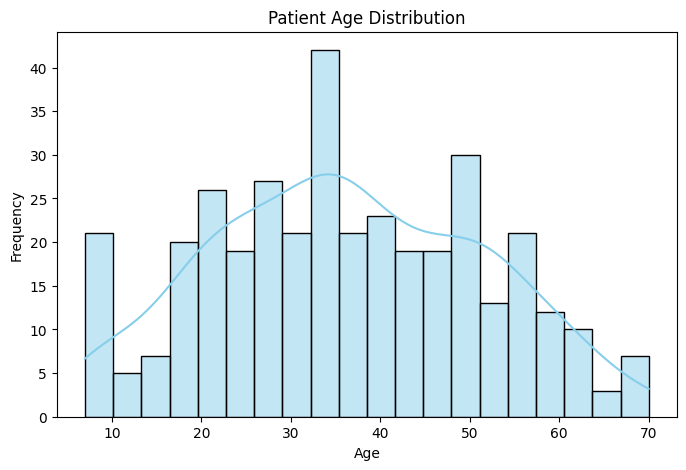

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(df_clean['age'], bins=20, kde=True, color='skyblue')
plt.title('Patient Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


/tmp/ipython-input-4021034377.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='erythema', data=df_clean, palette='Pastel1')


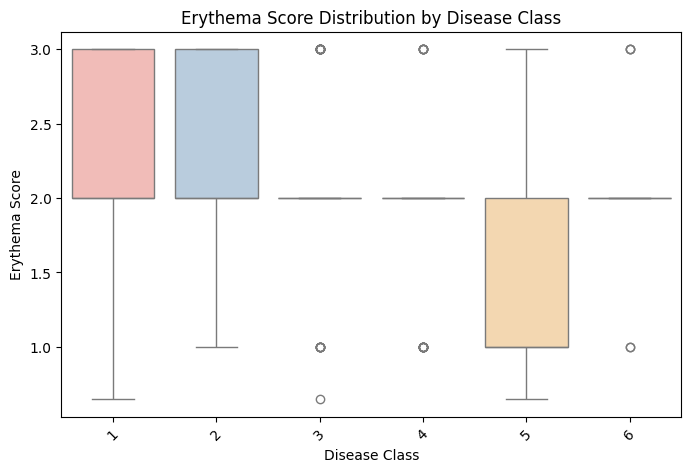

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='class', y='erythema', data=df_clean, palette='Pastel1')
plt.title('Erythema Score Distribution by Disease Class')
plt.xlabel('Disease Class')
plt.ylabel('Erythema Score')
plt.xticks(rotation=45)
plt.show()


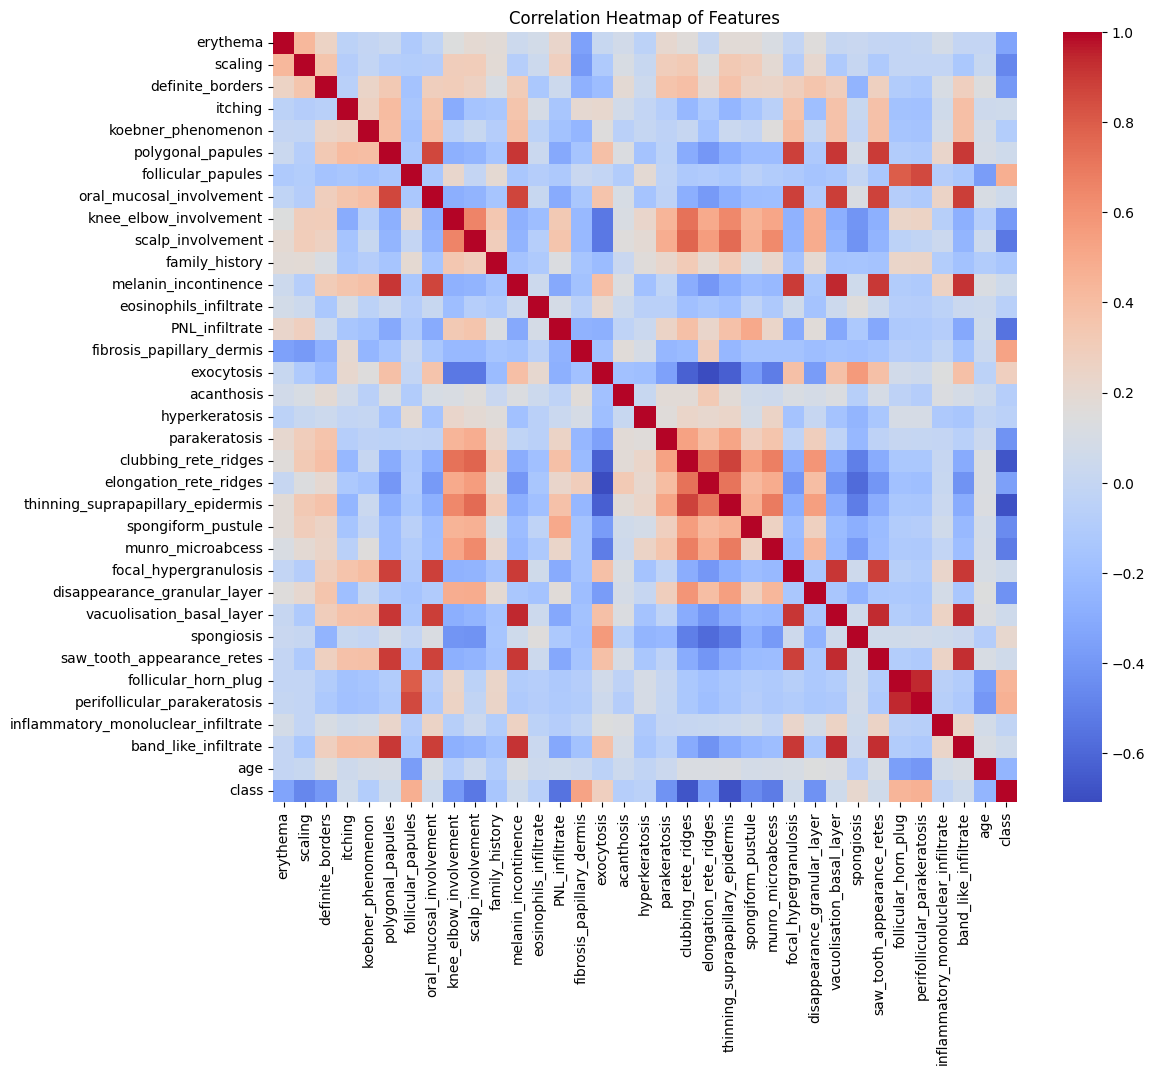

In [23]:
plt.figure(figsize=(12,10))
sns.heatmap(df_clean.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()


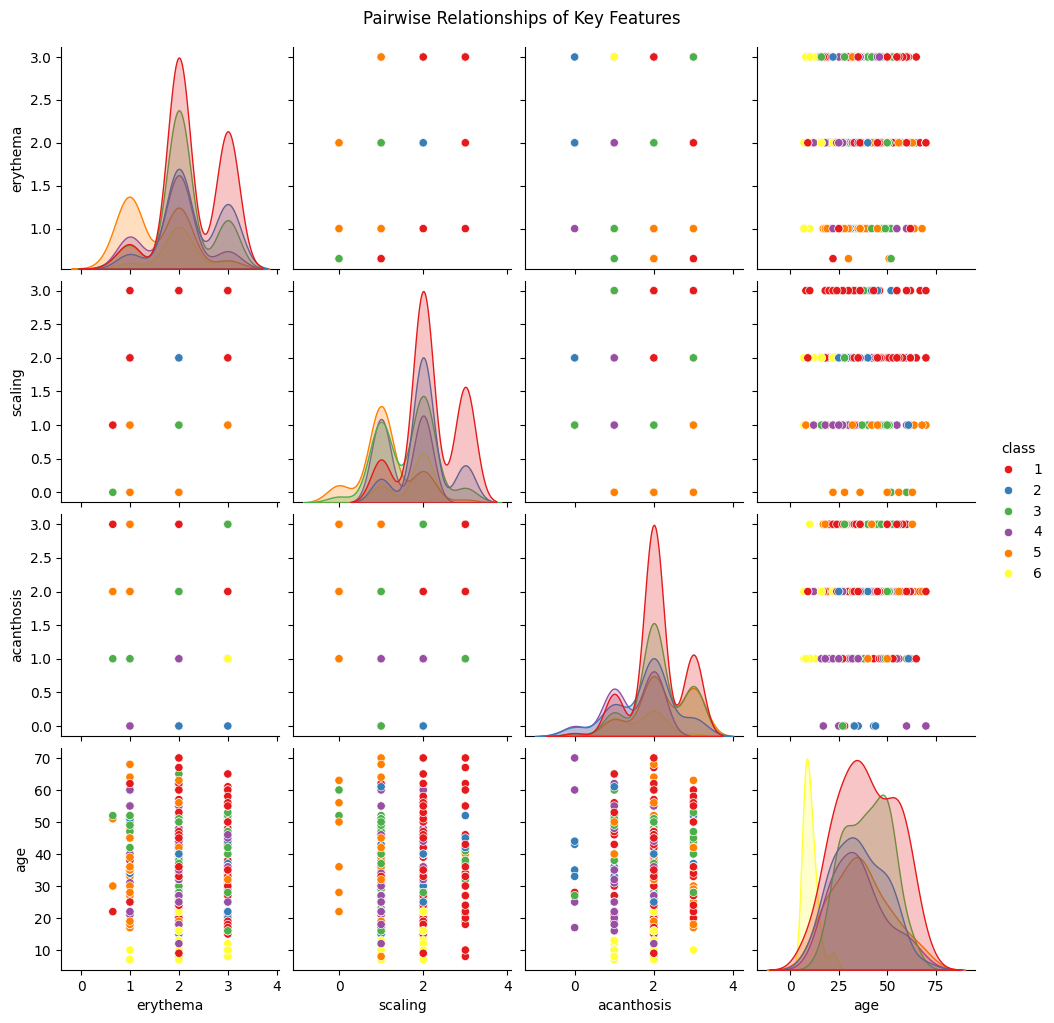

In [24]:
sns.pairplot(df_clean[['erythema','scaling','acanthosis','age','class']], hue='class', palette='Set1', diag_kind='kde')
plt.suptitle('Pairwise Relationships of Key Features', y=1.02)
plt.show()


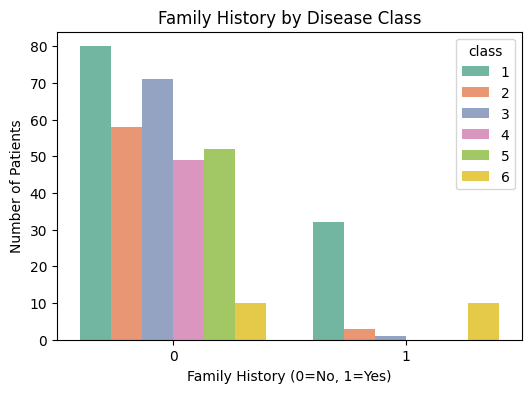

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='family_history', hue='class', data=df_clean, palette='Set2')
plt.title('Family History by Disease Class')
plt.xlabel('Family History (0=No, 1=Yes)')
plt.ylabel('Number of Patients')
plt.show()


/tmp/ipython-input-3970964096.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='age', data=df_clean, palette='Set3')


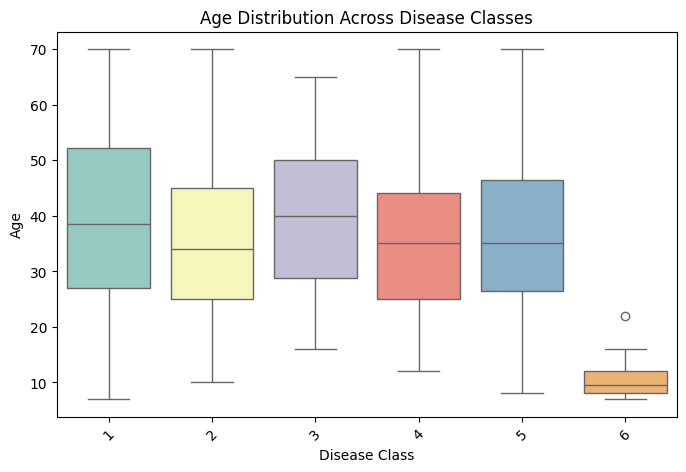

In [26]:
plt.figure(figsize=(8,5))
sns.boxplot(x='class', y='age', data=df_clean, palette='Set3')
plt.title('Age Distribution Across Disease Classes')
plt.xlabel('Disease Class')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-550011970.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y='acanthosis', data=df_clean, palette='Pastel2')


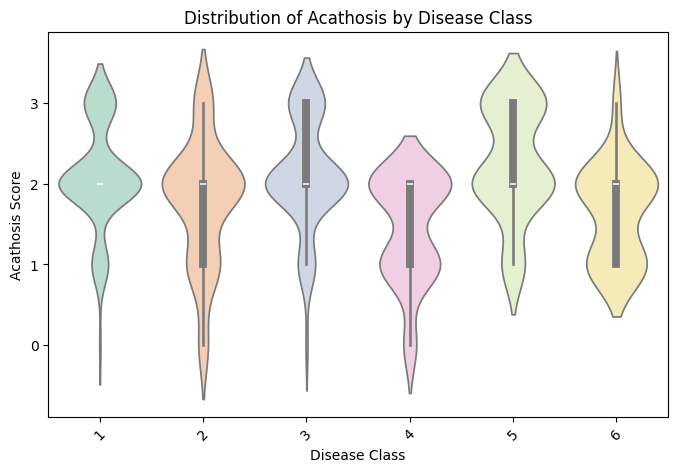

In [27]:
plt.figure(figsize=(8,5))
sns.violinplot(x='class', y='acanthosis', data=df_clean, palette='Pastel2')
plt.title('Distribution of Acathosis by Disease Class')
plt.xlabel('Disease Class')
plt.ylabel('Acathosis Score')
plt.xticks(rotation=45)
plt.show()


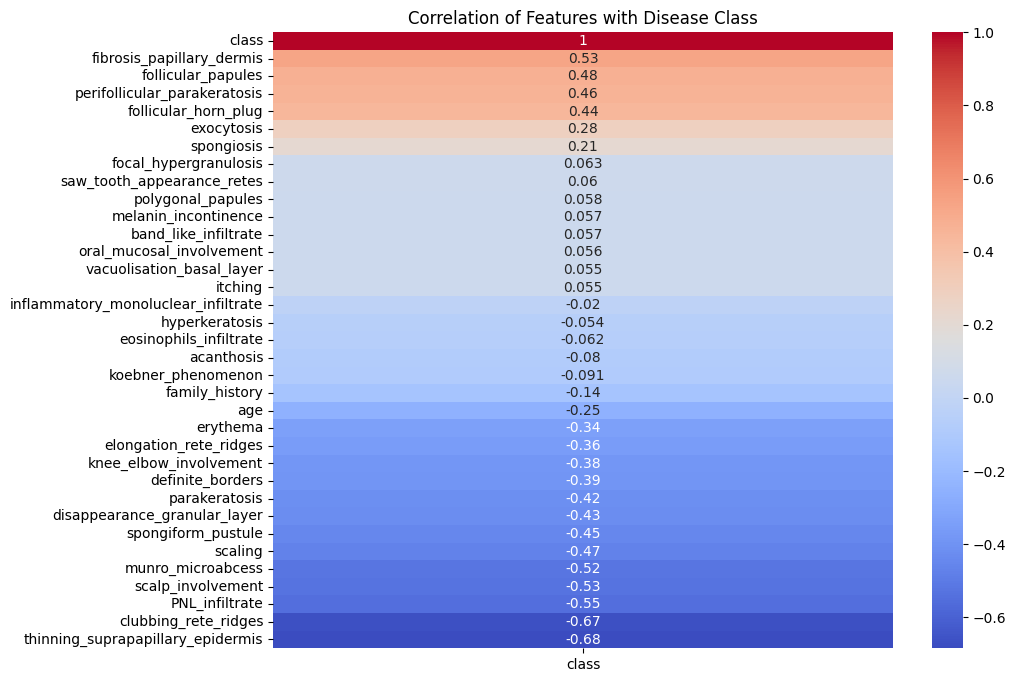

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(df_clean.corr()[['class']].sort_values(by='class', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Disease Class')
plt.show()


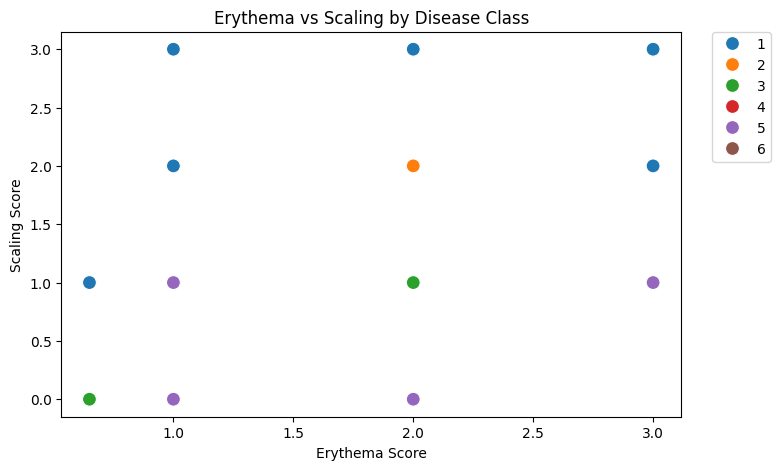

In [29]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='erythema', y='scaling', hue='class', data=df_clean, palette='tab10', s=100)
plt.title('Erythema vs Scaling by Disease Class')
plt.xlabel('Erythema Score')
plt.ylabel('Scaling Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
